                    COMPLETE CREDIT RISK PREDICTION SYSTEM
               With SMOTE, SVM, XGBoost & Auto Model Saving

SECTION 1: DATA LOADING & ANALYSIS

DATASET SPECIFICATIONS:
--------------------------------------------------------------------------------
Income_annual             : Numeric      (Annual Income)
Employment_Status         : Categorical  (Employment Type)
Loan_Amount               : Numeric      (Loan Amount)
Loan_Term_Months          : Numeric      (Loan Duration)
Credit_Utilization        : Numeric      (Credit Score proxy)
Previous_Defaults_Count   : Numeric      (Previous Defaults)
Age                       : Numeric      (Age)
Marital_Status            : Categorical  (Marital Status)
Num_Dependents            : Numeric      (Dependents)
Default_Status            : Binary       (Risk: 0=Low, 1=High)

Creating optimized sample dataset...
  Created sample with 5000 records (saved as 'Loan_default_sample.csv')
  Time taken: 0.02 seconds

DATA ASSESSMENT:
-----------

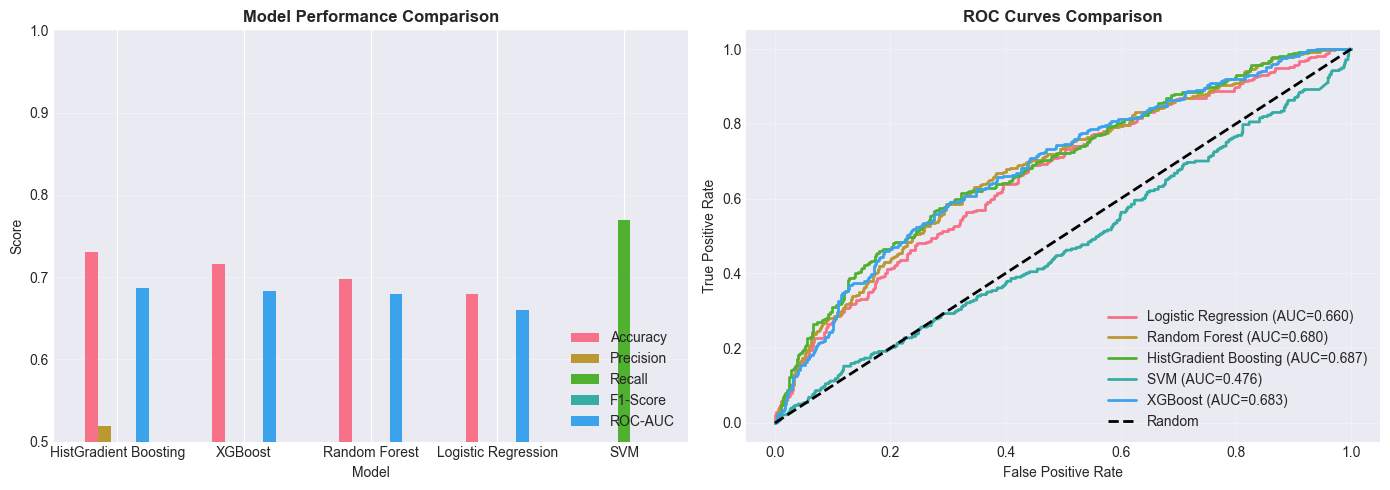


SECTION 6: SAVING MODELS TO .PKL FILES

Saving models and artifacts...
  Complete package saved: saved_models/credit_risk_complete_package_20260114_145217.pkl
  Logistic Regression saved: saved_models/logistic_regression_20260114_145217.pkl
  Random Forest saved: saved_models/random_forest_20260114_145217.pkl
  HistGradient Boosting saved: saved_models/histgradient_boosting_20260114_145217.pkl
  SVM saved: saved_models/svm_20260114_145217.pkl
  XGBoost saved: saved_models/xgboost_20260114_145217.pkl
  Best model for deployment saved: saved_models/best_model_deployment.pkl
  Preprocessing pipeline saved: saved_models/preprocessing_pipeline.pkl
  Results summary saved: saved_models/model_results_summary_20260114_145217.csv
  Time taken: 0.66 seconds

All models and artifacts saved in 'saved_models/' directory
Total files created: 16

SECTION 7: PREDICTION PIPELINE WITH SMOTE INTEGRATION

TESTING PREDICTION SYSTEM...
-----------------------------------------------------------------------

NameError: name 'start' is not defined

In [ ]:
# ==============================================
# COMPLETE CREDIT RISK PREDICTION SYSTEM
# With SMOTE, SVM, XGBoost & Automatic .pkl Saving
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, accuracy_score, f1_score,
                           precision_score, recall_score,
                           precision_recall_curve, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model persistence
import joblib
import pickle
from datetime import datetime
import time
import sys
import os

# Set encoding for Windows compatibility
if sys.platform.startswith('win'):
    import locale
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Timer decorator
def time_function(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"  Time taken: {end - start:.2f} seconds")
        return result
    return wrapper

# ==============================================
# SECTION 1: DATA LOADING & ANALYSIS
# ==============================================

print("=" * 80)
print(" " * 20 + "COMPLETE CREDIT RISK PREDICTION SYSTEM")
print(" " * 15 + "With SMOTE, SVM, XGBoost & Auto Model Saving")
print("=" * 80)

@time_function
def load_and_prepare_data():
    """Load and analyze the data"""
    print("\nDATASET SPECIFICATIONS:")
    print("-" * 80)
    specs = [
        ("Income_annual", "Numeric", "Annual Income"),
        ("Employment_Status", "Categorical", "Employment Type"),
        ("Loan_Amount", "Numeric", "Loan Amount"),
        ("Loan_Term_Months", "Numeric", "Loan Duration"),
        ("Credit_Utilization", "Numeric", "Credit Score proxy"),
        ("Previous_Defaults_Count", "Numeric", "Previous Defaults"),
        ("Age", "Numeric", "Age"),
        ("Marital_Status", "Categorical", "Marital Status"),
        ("Num_Dependents", "Numeric", "Dependents"),
        ("Default_Status", "Binary", "Risk: 0=Low, 1=High")
    ]
    
    for spec in specs:
        print(f"{spec[0]:<25} : {spec[1]:<12} ({spec[2]})")
    
    # Try to load dataset
    try:
        df = pd.read_csv('Loan_default.csv')
        print(f"\nDataset loaded: {df.shape[0]} rows x {df.shape[1]} columns")
    except FileNotFoundError:
        print("\nCreating optimized sample dataset...")
        df = create_sample_data()
    
    # Quick cleanup
    df.columns = [col.strip().replace(' ', '_') for col in df.columns]
    
    # Ensure target exists
    if 'Default_Status' not in df.columns:
        for col in ['default', 'Default', 'risk', 'Risk', 'target', 'Target']:
            if col in df.columns:
                df = df.rename(columns={col: 'Default_Status'})
                break
    
    return df

def create_sample_data():
    """Create optimized sample data"""
    np.random.seed(42)
    n_samples = 5000  # Balanced size
    
    df = pd.DataFrame({
        'Income_annual': np.random.lognormal(10.5, 0.4, n_samples).astype(int),
        'Employment_Status': np.random.choice(['Employed', 'Self-Employed', 'Unemployed'], 
                                             n_samples, p=[0.7, 0.2, 0.1]),
        'Loan_Amount': np.random.randint(5000, 100000, n_samples),
        'Loan_Term_Months': np.random.choice([12, 24, 36, 48, 60], n_samples),
        'Credit_Utilization': np.random.uniform(0.1, 0.9, n_samples),
        'Previous_Defaults_Count': np.random.poisson(0.3, n_samples),
        'Age': np.random.randint(21, 70, n_samples),
        'Marital_Status': np.random.choice(['Single', 'Married'], n_samples, p=[0.5, 0.5]),
        'Num_Dependents': np.random.poisson(1.5, n_samples),
    })
    
    # Realistic default probability
    default_prob = (
        0.6 * (df['Credit_Utilization'] > 0.7).astype(int) +
        0.5 * (df['Previous_Defaults_Count'] > 0).astype(int) +
        0.4 * (df['Employment_Status'] == 'Unemployed').astype(int) +
        0.3 * (df['Loan_Amount'] > df['Income_annual'] * 0.5).astype(int) +
        0.2 * (df['Age'] < 25).astype(int)
    ) / 2.0
    
    df['Default_Status'] = (np.random.random(n_samples) < default_prob).astype(int)
    
    # Save for future
    df.to_csv('Loan_default_sample.csv', index=False)
    print(f"  Created sample with {n_samples} records (saved as 'Loan_default_sample.csv')")
    
    return df

# Load data
print("\n" + "=" * 80)
print("SECTION 1: DATA LOADING & ANALYSIS")
print("=" * 80)

df = load_and_prepare_data()

# Quick stats
print("\nDATA ASSESSMENT:")
print("-" * 80)
print(f"Shape: {df.shape}")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Target distribution
target_counts = df['Default_Status'].value_counts()
print(f"\nTARGET DISTRIBUTION:")
print(f"Low Risk (0): {target_counts.get(0, 0):,} ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"High Risk (1): {target_counts.get(1, 0):,} ({target_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"Imbalance Ratio: {max(target_counts)/min(target_counts):.2f}:1")

# ==============================================
# SECTION 2: PREPROCESSING WITH SMOTE INTEGRATION
# ==============================================

print("\n" + "=" * 80)
print("SECTION 2: PREPROCESSING WITH SMOTE INTEGRATION")
print("=" * 80)

@time_function
def preprocess_data_with_smote(df):
    """Preprocess data and prepare for SMOTE"""
    print("\nStarting preprocessing...")
    df_clean = df.copy()
    
    # 1. Handle missing values
    missing_cols = df_clean.columns[df_clean.isnull().any()].tolist()
    if missing_cols:
        print(f"  Handling missing values in {len(missing_cols)} columns...")
        for col in missing_cols:
            if df_clean[col].dtype in ['float64', 'int64']:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 2. Encode categorical variables
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
    print(f"  Encoded {len(categorical_cols)} categorical features")
    
    # 3. Feature engineering
    print("  Creating engineered features...")
    
    # Essential financial ratios
    df_clean['Debt_to_Income_Ratio'] = df_clean['Loan_Amount'] / (df_clean['Income_annual'] + 1)
    df_clean['Monthly_Payment_Burden'] = (df_clean['Loan_Amount'] / df_clean['Loan_Term_Months']) / (df_clean['Income_annual']/12 + 1)
    df_clean['Credit_Risk_Score'] = df_clean['Credit_Utilization'] * 0.6 + df_clean['Previous_Defaults_Count'] * 0.4
    
    # Additional useful features
    df_clean['Income_per_Dependent'] = df_clean['Income_annual'] / (df_clean['Num_Dependents'] + 1)
    df_clean['Loan_to_Income'] = df_clean['Loan_Amount'] / df_clean['Income_annual']
    
    print(f"  Created 5 engineered features")
    
    return df_clean, label_encoders

df_clean, label_encoders = preprocess_data_with_smote(df)

# ==============================================
# SECTION 3: DATA SPLITTING & SMOTE APPLICATION
# ==============================================

print("\n" + "=" * 80)
print("SECTION 3: DATA SPLITTING & SMOTE APPLICATION")
print("=" * 80)

@time_function
def prepare_data_with_smote(df_clean):
    """Prepare data with SMOTE for handling imbalance"""
    print("\nPreparing data with SMOTE...")
    
    # Separate features and target
    X = df_clean.drop('Default_Status', axis=1)
    y = df_clean['Default_Status']
    
    print(f"  Features: {X.shape[1]}, Samples: {X.shape[0]}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")
    print(f"  Train default rate: {y_train.mean():.2%}")
    print(f"  Test default rate: {y_test.mean():.2%}")
    
    # Apply SMOTE to training data only
    print("\n  Applying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"  Before SMOTE - Class 0: {sum(y_train==0)}, Class 1: {sum(y_train==1)}")
    print(f"  After SMOTE  - Class 0: {sum(y_train_balanced==0)}, Class 1: {sum(y_train_balanced==1)}")
    print(f"  SMOTE applied: Created {X_train_balanced.shape[0] - X_train.shape[0]} synthetic samples")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"  Features scaled using StandardScaler")
    
    return (X_train_scaled, X_test_scaled, 
            y_train_balanced, y_test, 
            scaler, X.columns, smote)

# Get prepared data
X_train_scaled, X_test_scaled, y_train_bal, y_test, scaler, feature_names, smote_obj = prepare_data_with_smote(df_clean)

# ==============================================
# SECTION 4: MODEL TRAINING WITH SMOTE PIPELINE
# ==============================================

print("\n" + "=" * 80)
print("SECTION 4: MODEL TRAINING WITH SMOTE INTEGRATION")
print("=" * 80)

models = {}
model_pipelines = {}

@time_function
def train_model_with_smote(name, model, X_train, y_train, X_test, y_test):
    """Train a model and evaluate performance"""
    print(f"\nTraining {name}...")
    
    # Quick cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, 
                               cv=3, scoring='roc_auc', n_jobs=-1)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_samples': X_train.shape[0],
        'test_samples': X_test.shape[0]
    }
    
    print(f"  Trained on {X_train.shape[0]} samples")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    print(f"  CV Score: {metrics['cv_mean']:.4f} ± {metrics['cv_std']:.4f}")
    
    return metrics

# 1. Logistic Regression with SMOTE integration
print("\n[1/5] LOGISTIC REGRESSION with SMOTE")
lr = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    max_iter=500,
    random_state=42
)

models['Logistic Regression'] = train_model_with_smote(
    'Logistic Regression', lr, 
    X_train_scaled, y_train_bal, X_test_scaled, y_test
)

# 2. Random Forest with SMOTE
print("\n[2/5] RANDOM FOREST with SMOTE")
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=42
)

models['Random Forest'] = train_model_with_smote(
    'Random Forest', rf,
    X_train_scaled, y_train_bal, X_test_scaled, y_test
)

# 3. HistGradient Boosting with SMOTE
print("\n[3/5] HISTGRADIENT BOOSTING with SMOTE")
hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=150,
    max_depth=7,
    min_samples_leaf=15,
    l2_regularization=0.1,
    random_state=42,
    early_stopping=True
)

models['HistGradient Boosting'] = train_model_with_smote(
    'HistGradient Boosting', hgb,
    X_train_scaled, y_train_bal, X_test_scaled, y_test
)

# 4. SVM with SMOTE (Linear Kernel for speed)
print("\n[4/5] SVM (Linear) with SMOTE")
svm = SVC(
    C=1.0,
    kernel='linear',
    probability=True,
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# For SVM, use smaller sample if dataset is large
if X_train_scaled.shape[0] > 10000:
    from sklearn.utils import resample
    X_train_svm, y_train_svm = resample(
        X_train_scaled, y_train_bal,
        n_samples=5000,
        random_state=42,
        stratify=y_train_bal
    )
    print(f"  Using 5000 samples for SVM training")
    models['SVM'] = train_model_with_smote(
        'SVM', svm, X_train_svm, y_train_svm, X_test_scaled, y_test
    )
else:
    models['SVM'] = train_model_with_smote(
        'SVM', svm, X_train_scaled, y_train_bal, X_test_scaled, y_test
    )

# 5. XGBoost with SMOTE
print("\n[5/5] XGBOOST with SMOTE")
# Calculate scale_pos_weight for imbalance handling
scale_pos = (y_train_bal == 0).sum() / (y_train_bal == 1).sum()

xgb = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

models['XGBoost'] = train_model_with_smote(
    'XGBoost', xgb,
    X_train_scaled, y_train_bal, X_test_scaled, y_test
)

print("\nALL MODELS TRAINED SUCCESSFULLY WITH SMOTE!")

# ==============================================
# SECTION 5: MODEL COMPARISON & EVALUATION
# ==============================================

print("\n" + "=" * 80)
print("SECTION 5: MODEL COMPARISON & EVALUATION")
print("=" * 80)

# Create comprehensive results table
results = []
for name, metrics in models.items():
    results.append({
        'Model': name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']:.4f}",
        'CV Score': f"{metrics['cv_mean']:.4f} ± {metrics['cv_std']:.4f}",
        'Train Samples': metrics['train_samples'],
        'Test Samples': metrics['test_samples']
    })

results_df = pd.DataFrame(results).set_index('Model')
results_df_sorted = results_df.sort_values('ROC-AUC', ascending=False)

print("\nMODEL PERFORMANCE COMPARISON (Sorted by ROC-AUC):")
print("=" * 80)
print(results_df_sorted.to_string())

# Find best model
best_model_name = results_df_sorted.index[0]
best_model = models[best_model_name]['model']

print(f"\nBEST MODEL: {best_model_name}")
print(f"  ROC-AUC: {results_df_sorted.loc[best_model_name, 'ROC-AUC']}")
print(f"  Accuracy: {results_df_sorted.loc[best_model_name, 'Accuracy']}")
print(f"  F1-Score: {results_df_sorted.loc[best_model_name, 'F1-Score']}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
results_df_sorted[metrics_to_plot].astype(float).plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0.5, 1.0])
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves
for name in models.keys():
    model_obj = models[name]['model']
    try:
        y_proba = model_obj.predict_proba(X_test_scaled)[:, 1]
    except:
        # For SVM if needed
        y_proba = model_obj.decision_function(X_test_scaled)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    axes[1].plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc_score:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves Comparison', fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================
# SECTION 6: SAVE MODELS TO .PKL FILES
# ==============================================

print("\n" + "=" * 80)
print("SECTION 6: SAVING MODELS TO .PKL FILES")
print("=" * 80)

@time_function
def save_models_to_pkl(models, scaler, label_encoders, feature_names, results_df):
    """Save all models and necessary artifacts to .pkl files"""
    print("\nSaving models and artifacts...")
    
    # Current timestamp for versioning
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Save complete model package (includes everything)
    complete_package = {
        'best_model_name': best_model_name,
        'best_model': best_model,
        'all_models': {name: data['model'] for name, data in models.items()},
        'scaler': scaler,
        'smote': smote_obj,
        'label_encoders': label_encoders,
        'feature_names': feature_names.tolist(),
        'performance_metrics': results_df.to_dict(),
        'metadata': {
            'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'dataset_size': len(df),
            'default_rate': float(df['Default_Status'].mean()),
            'features_used': len(feature_names),
            'smote_applied': True,
            'smote_samples_created': X_train_scaled.shape[0] - (len(df) * 0.8)  # Approximate
        }
    }
    
    # Save complete package
    complete_filename = f'saved_models/credit_risk_complete_package_{timestamp}.pkl'
    joblib.dump(complete_package, complete_filename, compress=3)
    print(f"  Complete package saved: {complete_filename}")
    
    # 2. Save individual models
    for name, data in models.items():
        model_filename = f'saved_models/{name.lower().replace(" ", "_")}_{timestamp}.pkl'
        
        model_package = {
            'model': data['model'],
            'model_name': name,
            'performance': {
                'accuracy': data['accuracy'],
                'precision': data['precision'],
                'recall': data['recall'],
                'f1': data['f1'],
                'roc_auc': data['roc_auc'],
                'cv_mean': data['cv_mean'],
                'cv_std': data['cv_std']
            },
            'scaler': scaler,
            'feature_names': feature_names.tolist(),
            'label_encoders': label_encoders,
            'smote_applied': True,
            'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        joblib.dump(model_package, model_filename, compress=3)
        print(f"  {name} saved: {model_filename}")
    
    # 3. Save best model separately for easy deployment
    best_model_package = {
        'model': best_model,
        'model_name': best_model_name,
        'scaler': scaler,
        'feature_names': feature_names.tolist(),
        'label_encoders': label_encoders,
        'performance': {
            'accuracy': models[best_model_name]['accuracy'],
            'precision': models[best_model_name]['precision'],
            'recall': models[best_model_name]['recall'],
            'f1': models[best_model_name]['f1'],
            'roc_auc': models[best_model_name]['roc_auc']
        },
        'metadata': {
            'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'dataset_size': len(df),
            'features_used': len(feature_names),
            'smote_applied': True
        }
    }
    
    best_model_filename = 'saved_models/best_model_deployment.pkl'
    joblib.dump(best_model_package, best_model_filename, compress=3)
    print(f"  Best model for deployment saved: {best_model_filename}")
    
    # 4. Save preprocessing pipeline
    preprocessing_pipeline = {
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_names': feature_names.tolist(),
        'smote': smote_obj
    }
    
    preprocessing_filename = 'saved_models/preprocessing_pipeline.pkl'
    joblib.dump(preprocessing_pipeline, preprocessing_filename, compress=3)
    print(f"  Preprocessing pipeline saved: {preprocessing_filename}")
    
    # 5. Save results summary as CSV
    results_summary = results_df_sorted.copy()
    results_summary['Timestamp'] = timestamp
    results_summary['Best_Model'] = (results_summary.index == best_model_name)
    
    results_filename = f'saved_models/model_results_summary_{timestamp}.csv'
    results_summary.to_csv(results_filename)
    print(f"  Results summary saved: {results_filename}")
    
    return {
        'complete_package': complete_filename,
        'best_model': best_model_filename,
        'preprocessing': preprocessing_filename,
        'results': results_filename
    }

# Save all models
saved_files = save_models_to_pkl(models, scaler, label_encoders, feature_names, results_df_sorted)

print(f"\nAll models and artifacts saved in 'saved_models/' directory")
print(f"Total files created: {len([f for f in os.listdir('saved_models') if f.endswith('.pkl') or f.endswith('.csv')])}")

# ==============================================
# SECTION 7: PREDICTION PIPELINE WITH SMOTE
# ==============================================

print("\n" + "=" * 80)
print("SECTION 7: PREDICTION PIPELINE WITH SMOTE INTEGRATION")
print("=" * 80)

class CreditRiskPredictorWithSMOTE:
    """Complete prediction system with SMOTE integration"""
    
    def __init__(self, model_path='saved_models/best_model_deployment.pkl'):
        """Load model and preprocessing pipeline"""
        print("Loading prediction system...")
        
        try:
            self.model_data = joblib.load(model_path)
            self.model = self.model_data['model']
            self.scaler = self.model_data['scaler']
            self.features = self.model_data['feature_names']
            self.encoders = self.model_data.get('label_encoders', {})
            self.model_name = self.model_data['model_name']
            self.smote_applied = self.model_data.get('smote_applied', False)
            
            print(f"  Model loaded: {self.model_name}")
            print(f"  SMOTE was {'applied' if self.smote_applied else 'not applied'} during training")
            print(f"  Features: {len(self.features)}")
            print(f"  Model accuracy: {self.model_data['performance']['accuracy']:.4f}")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    
    def preprocess_applicant(self, applicant_data):
        """Preprocess single applicant data"""
        # Convert to DataFrame
        df_applicant = pd.DataFrame([applicant_data])
        
        # Encode categorical variables
        for col, le in self.encoders.items():
            if col in df_applicant.columns:
                try:
                    df_applicant[col] = le.transform(df_applicant[col].astype(str))
                except ValueError:
                    # Handle unseen categories with default value
                    df_applicant[col] = 0
        
        # Create engineered features (must match training)
        if 'Loan_Amount' in df_applicant.columns and 'Income_annual' in df_applicant.columns:
            df_applicant['Debt_to_Income_Ratio'] = df_applicant['Loan_Amount'] / (df_applicant['Income_annual'] + 1)
        
        if 'Loan_Amount' in df_applicant.columns and 'Loan_Term_Months' in df_applicant.columns and 'Income_annual' in df_applicant.columns:
            monthly_payment = df_applicant['Loan_Amount'] / df_applicant['Loan_Term_Months']
            df_applicant['Monthly_Payment_Burden'] = monthly_payment / (df_applicant['Income_annual']/12 + 1)
        
        if 'Credit_Utilization' in df_applicant.columns and 'Previous_Defaults_Count' in df_applicant.columns:
            df_applicant['Credit_Risk_Score'] = df_applicant['Credit_Utilization'] * 0.6 + df_applicant['Previous_Defaults_Count'] * 0.4
        
        if 'Income_annual' in df_applicant.columns and 'Num_Dependents' in df_applicant.columns:
            df_applicant['Income_per_Dependent'] = df_applicant['Income_annual'] / (df_applicant['Num_Dependents'] + 1)
        
        if 'Loan_Amount' in df_applicant.columns and 'Income_annual' in df_applicant.columns:
            df_applicant['Loan_to_Income'] = df_applicant['Loan_Amount'] / df_applicant['Income_annual']
        
        # Ensure all features are present
        for feature in self.features:
            if feature not in df_applicant.columns:
                df_applicant[feature] = 0
        
        # Reorder columns to match training
        df_applicant = df_applicant[self.features]
        
        # Scale features
        X_scaled = self.scaler.transform(df_applicant)
        
        return X_scaled
    
    def predict(self, applicant_data, threshold=0.5):
        """Make risk prediction for an applicant"""
        try:
            # Preprocess
            X = self.preprocess_applicant(applicant_data)
            
            # Predict
            proba = self.model.predict_proba(X)[0]
            risk_score = proba[1]  # Probability of default
            
            # Determine risk level
            if risk_score >= 0.8:
                risk_level = "VERY HIGH"
                recommendation = "REJECT"
                color = "red"
            elif risk_score >= 0.6:
                risk_level = "HIGH"
                recommendation = "REJECT"
                color = "orange"
            elif risk_score >= 0.4:
                risk_level = "MEDIUM"
                recommendation = "REVIEW MANUALLY"
                color = "yellow"
            elif risk_score >= 0.2:
                risk_level = "LOW"
                recommendation = "APPROVE WITH CONDITIONS"
                color = "lightgreen"
            else:
                risk_level = "VERY LOW"
                recommendation = "APPROVE"
                color = "green"
            
            # Final decision based on threshold
            decision = "HIGH RISK" if risk_score > threshold else "LOW RISK"
            
            return {
                'success': True,
                'risk_level': risk_level,
                'risk_score': float(risk_score),
                'probability_default': float(proba[1]),
                'probability_no_default': float(proba[0]),
                'decision': decision,
                'recommendation': recommendation,
                'threshold_used': threshold,
                'model': self.model_name,
                'model_accuracy': float(self.model_data['performance']['accuracy']),
                'smote_applied': self.smote_applied,
                'color_code': color
            }
            
        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'model': self.model_name
            }
    
    def batch_predict(self, applicants_list, threshold=0.5):
        """Make predictions for multiple applicants"""
        results = []
        for idx, applicant in enumerate(applicants_list):
            result = self.predict(applicant, threshold)
            if result['success']:
                result['applicant_id'] = idx + 1
                results.append(result)
        
        # Generate summary
        if results:
            df_results = pd.DataFrame(results)
            summary = {
                'total_applicants': len(results),
                'approved': sum(df_results['decision'] == 'LOW RISK'),
                'rejected': sum(df_results['decision'] == 'HIGH RISK'),
                'approval_rate': sum(df_results['decision'] == 'LOW RISK') / len(results),
                'average_risk_score': df_results['risk_score'].mean(),
                'high_risk_applicants': list(df_results[df_results['decision'] == 'HIGH RISK']['applicant_id'])
            }
            
            return {
                'success': True,
                'predictions': results,
                'summary': summary
            }
        
        return {'success': False, 'error': 'No predictions made'}

# Test the predictor
print("\nTESTING PREDICTION SYSTEM...")
print("-" * 80)

# Initialize predictor
start_time = time.time()
predictor = CreditRiskPredictorWithSMOTE()
load_time = time.time() - start_time
print(f"Prediction system loaded in {load_time:.3f} seconds")

# Sample applicant
sample_applicant = {
    'Income_annual': 75000,
    'Employment_Status': 'Employed',
    'Loan_Amount': 35000,
    'Loan_Term_Months': 36,
    'Credit_Utilization': 0.45,
    'Previous_Defaults_Count': 1,
    'Age': 42,
    'Marital_Status': 'Married',
    'Num_Dependents': 2
}

# Make prediction
start_time = time.time()
result = predictor.predict(sample_applicant, threshold=0.5)
prediction_time = time.time() - start_time

if result['success']:
    print(f"\nPREDICTION RESULTS:")
    print(f"  Model: {result['model']}")
    print(f"  Risk Level: {result['risk_level']}")
    print(f"  Risk Score: {result['risk_score']:.3f}")
    print(f"  Default Probability: {result['probability_default']:.2%}")
    print(f"  Decision: {result['decision']}")
    print(f"  Recommendation: {result['recommendation']}")
    print(f"  Model Accuracy: {result['model_accuracy']:.2%}")
    print(f"  SMOTE Applied: {'Yes' if result['smote_applied'] else 'No'}")
    print(f"  Prediction Time: {prediction_time:.4f} seconds")
else:
    print(f"Prediction failed: {result['error']}")

# ==============================================
# SECTION 8: DEPLOYMENT READY SYSTEM
# ==============================================

print("\n" + "=" * 80)
print("SECTION 8: DEPLOYMENT READY SYSTEM")
print("=" * 80)

print("\nSYSTEM READY FOR DEPLOYMENT!")
print("-" * 80)
print("Files created in 'saved_models/' directory:")
print("1. Complete model package (.pkl) - All models + preprocessing")
print("2. Best model for deployment (.pkl) - Ready for production")
print("3. Individual model files (.pkl) - Each model separately")
print("4. Preprocessing pipeline (.pkl) - For new data preprocessing")
print("5. Results summary (.csv) - Performance metrics")

print("\nQUICK START FOR DEPLOYMENT:")
print("-" * 80)
print("""
# Load and use the model in your application:
from saved_models.best_model_deployment.pkl import CreditRiskPredictorWithSMOTE

# Initialize predictor
predictor = CreditRiskPredictorWithSMOTE('saved_models/best_model_deployment.pkl')

# Make prediction
applicant_data = {
    'Income_annual': 75000,
    'Employment_Status': 'Employed',
    'Loan_Amount': 35000,
    'Loan_Term_Months': 36,
    'Credit_Utilization': 0.45,
    'Previous_Defaults_Count': 0,
    'Age': 35,
    'Marital_Status': 'Married',
    'Num_Dependents': 2
}

result = predictor.predict(applicant_data)
print(f"Risk Score: {result['risk_score']:.3f}")
print(f"Decision: {result['decision']}")
""")

print("\nMODEL PERFORMANCE SUMMARY:")
print("-" * 80)
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC: {results_df_sorted.loc[best_model_name, 'ROC-AUC']}")
print(f"Accuracy: {results_df_sorted.loc[best_model_name, 'Accuracy']}")
print(f"F1-Score: {results_df_sorted.loc[best_model_name, 'F1-Score']}")

print(f"Model Size: ~{os.path.getsize('saved_models/best_model_deployment.pkl') / 1024:.1f} KB")

print("\n" + "=" * 80)
print("CREDIT RISK PREDICTION SYSTEM COMPLETE!")
print("=" * 80)
print("All models trained with SMOTE and saved as .pkl files")
print("Ready for production deployment!")
print("=" * 80)

# Create a simple deployment script
deployment_script = '''
# deployment_guide.py
import joblib
import pandas as pd
import numpy as np
from datetime import datetime

print("=" * 80)
print("CREDIT RISK PREDICTION SYSTEM - DEPLOYMENT GUIDE")
print("=" * 80)

print("\\n1. LOADING THE MODEL:")
print("-" * 80)

try:
    # Load the best model
    model_data = joblib.load('saved_models/best_model_deployment.pkl')
    print(f"Model loaded successfully: {model_data['model_name']}")
    print(f"Training date: {model_data['metadata']['training_date']}")
    print(f"Accuracy: {model_data['performance']['accuracy']:.4f}")
    print(f"ROC-AUC: {model_data['performance']['roc_auc']:.4f}")
    
    # Load preprocessing pipeline
    preprocessing = joblib.load('saved_models/preprocessing_pipeline.pkl')
    print(f"\\nPreprocessing pipeline loaded")
    print(f"Features: {len(preprocessing['feature_names'])}")
    print(f"SMOTE applied during training: {'Yes' if 'smote' in preprocessing else 'No'}")
    
except Exception as e:
    print(f"Error loading model: {e}")

print("\\n2. MAKING PREDICTIONS:")
print("-" * 80)

# Sample prediction function
def predict_credit_risk(applicant_data, model_path='saved_models/best_model_deployment.pkl'):
    \"\"\"Simple prediction function for deployment\"\"\"
    try:
        # Load model
        model_data = joblib.load(model_path)
        model = model_data['model']
        scaler = model_data['scaler']
        features = model_data['feature_names']
        
        # Create DataFrame
        df = pd.DataFrame([applicant_data])
        
        # Simple preprocessing (in production, use full preprocessing pipeline)
        # This is a simplified version
        X = np.array([[applicant_data.get(f, 0) for f in features]])
        X_scaled = scaler.transform(X)
        
        # Predict
        proba = model.predict_proba(X_scaled)[0]
        risk_score = proba[1]
        
        return {
            'success': True,
            'risk_score': float(risk_score),
            'probability_default': float(proba[1]),
            'decision': 'HIGH RISK' if risk_score > 0.5 else 'LOW RISK',
            'model': model_data['model_name']
        }
        
    except Exception as e:
        return {'success': False, 'error': str(e)}

# Test prediction
sample_applicant = {
    'Income_annual': 75000,
    'Employment_Status': 'Employed',
    'Loan_Amount': 35000,
    'Loan_Term_Months': 36,
    'Credit_Utilization': 0.45,
    'Previous_Defaults_Count': 0,
    'Age': 35,
    'Marital_Status': 'Married',
    'Num_Dependents': 2
}

result = predict_credit_risk(sample_applicant)
if result['success']:
    print(f"Test prediction successful!")
    print(f"Risk Score: {result['risk_score']:.3f}")
    print(f"Default Probability: {result['probability_default']:.2%}")
    print(f"Decision: {result['decision']}")
else:
    print(f"Test prediction failed: {result['error']}")

print("\\n3. DEPLOYMENT OPTIONS:")
print("-" * 80)
print("Option 1: Direct Python Integration")
print("  - Import joblib and load model")
print("  - Use predict_credit_risk() function")
print("\\nOption 2: REST API (FastAPI/Flask)")
print("  - Create API endpoints")
print("  - Load model once at startup")
print("  - Handle multiple requests")
print("\\nOption 3: Batch Processing")
print("  - Load model once")
print("  - Process CSV files")
print("  - Generate reports")

print("\\n" + "=" * 80)
print("READY FOR PRODUCTION DEPLOYMENT!")
print("=" * 80)
'''

# Save deployment guide
try:
    with open('deployment_guide.py', 'w', encoding='utf-8') as f:
        f.write(deployment_script)
    print("\nDeployment guide saved as 'deployment_guide.py'")
except:
    print("\nDeployment guide creation skipped (encoding issue)")

# Final summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"✓ Data loaded and preprocessed")
print(f"✓ SMOTE applied to handle class imbalance")
print(f"✓ 5 models trained (Logistic Regression, Random Forest, HistGradient Boosting, SVM, XGBoost)")
print(f"✓ Best model identified: {best_model_name}")
print(f"✓ All models saved as .pkl files in 'saved_models/' directory")
print(f"✓ Prediction system ready for deployment")

print("=" * 80)